# CHATILYZER -- WhatsApp Chat Analysis using NLP

In [1]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Importing Necessary Libraries

In [2]:
import regex
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import MaxNLocator
from plotly import express as px
import plotly.graph_objects as go
import seaborn as sns
from datetime import *
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
wordnet_lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS

# PREPROCESSING

## STEP 1: Detecting Date and Time Tokens

In [3]:
def startsWithDate(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

## STEP 2: Detecting Author Token

In [4]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = regex.match(pattern, s)
    if result:
        return True
    return False

## STEP 3: Extracting and Combining tokens

In [5]:
def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")         # Date and Time tokens
    message = " ".join(splitline[1:])
    if startsWithAuthor(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]              # Author token
        message = " ".join(splitmessage[1:])  # Message
    else:
        author= None
    return date, time, author, message

## STEP 4: Parsing the Chat file

In [6]:
data = []
conversation = '/content/drive/MyDrive/Chatilyzer/chat_data.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()   # Remove spaces at the beginning and at the end of the string
        if startsWithDate(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
          messageBuffer.append(line)

## STEP 5: Dataframe Creation and Preprocessing

In [7]:
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df

,Date,Time,Author,Message
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year
1,2020-05-02,10:01 am,Ed,<Media omitted>
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣
3,2020-05-02,10:01 am,Rohit,💪🏾
4,2020-05-02,10:01 am,Rohit,yeah
...,...,...,...,...
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?
4692,2020-09-21,2:25 pm,Ed,You deleted this message
4693,2020-09-21,2:26 pm,Ed,<Media omitted>
4694,2020-09-21,2:26 pm,Rohit,onz onz


In [9]:
df.tail(10)

,Date,Time,Author,Message
4686,2020-09-20,12:53 pm,Ed,Then if can I credit you two in my write up
4687,2020-09-20,12:56 pm,Ed,@60197773622 tha ya
4688,2020-09-20,1:01 pm,Rohit,Hahaha I ok je la see my name on your report 😃...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message
4690,2020-09-20,1:06 pm,Ed,😂 😂
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?
4692,2020-09-21,2:25 pm,Ed,You deleted this message
4693,2020-09-21,2:26 pm,Ed,<Media omitted>
4694,2020-09-21,2:26 pm,Rohit,onz onz
4695,2020-09-21,2:26 pm,Ed,This is what I call English song. Good old fays


In [10]:
df.shape

(4696, 4)

In [11]:
df.isnull().sum()

Date       0
Time       0
Author     0
Message    0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4696 entries, 0 to 4695
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     4696 non-null   datetime64[ns]
 1   Time     4696 non-null   object        
 2   Author   4696 non-null   object        
 3   Message  4696 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 146.9+ KB


In [13]:
df.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Date,Time,Author,Message
count,4696,4696,4696,4696
unique,46,757,2,3878
top,2020-05-02 00:00:00,12:21 pm,Rohit,<Media omitted>
freq,492,31,2556,263
first,2020-01-07 00:00:00,NaN,NaN,NaN
last,2020-12-06 00:00:00,NaN,NaN,NaN


In [14]:
# Number of unique Authors
df['Author'].nunique()

2

In [15]:
# Unique Authors in the chat
df.Author.unique()

array(['Ed', 'Rohit'], dtype=object)

In [16]:
# Displaying total number of messages in the chat
total_messages = df.shape[0]
print(total_messages)

4696


In [17]:
# Displaying omitted media while exporting
media_messages = df[df["Message"]=='<Media omitted>'].shape[0]
print(media_messages)

263


In [18]:
# Adding one more column of "Day"
weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}
df['Day'] = df['Date'].dt.weekday.map(weeks)

In [19]:
# Rearranging the columns for better understanding
df = df[['Date','Day','Time','Author','Message']]

In [20]:
# Changing the datatype of column "Day".
df['Day'] = df['Day'].astype('category')

In [21]:
df.head()

,Date,Day,Time,Author,Message
0,2020-05-02,Saturday,10:00 am,Ed,We share our knowledge here and pass year
1,2020-05-02,Saturday,10:01 am,Ed,<Media omitted>
2,2020-05-02,Saturday,10:01 am,Ed,Easy to communicate 🤣🤣🤣
3,2020-05-02,Saturday,10:01 am,Rohit,💪🏾
4,2020-05-02,Saturday,10:01 am,Rohit,yeah


In [22]:
# Counting number of letters in each message
df['Letter'] = df['Message'].apply(lambda s : len(s))

In [23]:
# Counting number of words in each message
df['Word'] = df['Message'].apply(lambda s : len(s.split(' ')))

In [24]:
# Function to count number of links in dataset, it will add extra column and store information in it.
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [25]:
# Function to count number of media in chat.
MEDIAPATTERN = r'<Media omitted>'
df['Media_Count'] = df.Message.apply(lambda x : regex.findall(MEDIAPATTERN, x)).str.len()
media = np.sum(df.Media_Count)

In [26]:
df.head(10) # Having a look at the first 10 entries

,Date,Day,Time,Author,Message,Letter,Word,urlcount,Media_Count
0,2020-05-02,Saturday,10:00 am,Ed,We share our knowledge here and pass year,41,8,0,0
1,2020-05-02,Saturday,10:01 am,Ed,<Media omitted>,15,2,0,1
2,2020-05-02,Saturday,10:01 am,Ed,Easy to communicate 🤣🤣🤣,23,4,0,0
3,2020-05-02,Saturday,10:01 am,Rohit,💪🏾,2,1,0,0
4,2020-05-02,Saturday,10:01 am,Rohit,yeah,4,1,0,0
5,2020-05-02,Saturday,12:22 pm,Ed,<Media omitted>,15,2,0,1
6,2020-05-02,Saturday,12:22 pm,Ed,Guys? Haha,10,2,0,0
7,2020-05-02,Saturday,12:38 pm,Ed,You deleted this message,24,4,0,0
8,2020-05-02,Saturday,12:38 pm,Ed,One of the answer,17,4,0,0
9,2020-05-02,Saturday,12:39 pm,Rohit,<Media omitted>,15,2,0,1


In [27]:
df

,Date,Day,Time,Author,Message,Letter,Word,urlcount,Media_Count
0,2020-05-02,Saturday,10:00 am,Ed,We share our knowledge here and pass year,41,8,0,0
1,2020-05-02,Saturday,10:01 am,Ed,<Media omitted>,15,2,0,1
2,2020-05-02,Saturday,10:01 am,Ed,Easy to communicate 🤣🤣🤣,23,4,0,0
3,2020-05-02,Saturday,10:01 am,Rohit,💪🏾,2,1,0,0
4,2020-05-02,Saturday,10:01 am,Rohit,yeah,4,1,0,0
...,...,...,...,...,...,...,...,...,...
4691,2020-09-20,Sunday,5:32 pm,Ed,who have finish math lecture ?,30,6,0,0
4692,2020-09-21,Monday,2:25 pm,Ed,You deleted this message,24,4,0,0
4693,2020-09-21,Monday,2:26 pm,Ed,<Media omitted>,15,2,0,1
4694,2020-09-21,Monday,2:26 pm,Rohit,onz onz,7,2,0,0


## STEP 6: Overall Statistics of the Chat

In [28]:
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
links = np.sum(df.urlcount)
print('Personal Chat Stats : ')
print('Total Number of Messages : {}'.format(total_messages))
print('Total Number of Media Messages : {}'.format(media_messages))
print('Total Number of Links : {}'.format(links))

Personal Chat Stats : 
Total Number of Messages : 4696
Total Number of Media Messages : 263
Total Number of Links : 17


## STEP 7: Extracting basic statistics for each Author

In [46]:
l = df.Author.unique()
for i in range(len(l)):

  # Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]

  # Messages of only one particular user
  print(f'****** Statistics of {l[i]} ******')

  # Number of messages
  print('Total Message Sent : ', req_df.shape[0])

  # Total words in one message
  words_per_message = (np.sum(req_df['Word']))/req_df.shape[0]
  w_p_m = ("%.3f" % round(words_per_message, 2))  
  print('Average Words per Message : ', w_p_m)

  # Media messages
  media = sum(req_df["Media_Count"])
  print('Total Media Message Sent : ', media)

  # Total links
  links = sum(req_df["urlcount"])   
  print('Total Links Sent : ', links)   
  print()
  print('----------------------------------')

****** Statistics of Ed ******
Total Message Sent :  2140
Average Words per Message :  3.890
Total Media Message Sent :  163
Total Links Sent :  4

----------------------------------
****** Statistics of Rohit ******
Total Message Sent :  2556
Average Words per Message :  5.610
Total Media Message Sent :  100
Total Links Sent :  13

----------------------------------


## STEP 8: Natural Language Processing

In [30]:
messages = []
stop_words = set(stopwords.words('english'))

for words in df['Message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)  

### Tokenization

Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens. Word tokenizer can be used to find the list of words in strings.

In [31]:
    tokens = nltk.word_tokenize(only_letters) 

### Convert all letters to lower case

In [32]:
    lower_case = [l.lower() for l in tokens] 

### Stopwords removal

Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document hece they are removed.

In [33]:
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

### Lemmatization 

Lemmatization is a method responsible for grouping different inflected forms of words into the root form, having the same meaning

In [34]:
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]  
    messages.append(' '.join(lemmas))    

# EXPLORATORY DATA ANALYSIS

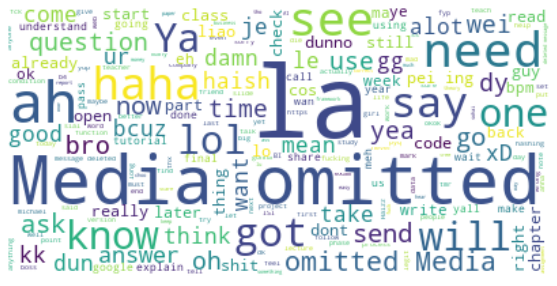

In [35]:
# Word Cloud
text = " ".join(review for review in df.Message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

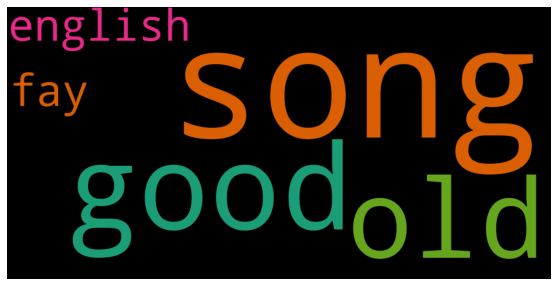

In [36]:
# Most important words in messages 
cv = CountVectorizer(analyzer = "word",stop_words = 'english',max_features = 20,ngram_range=(2,2))
important_words = cv.fit_transform(messages)
fig_words = cv.vocabulary_

# Wordcloud for important words 
unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 1000, height = 500,colormap="Dark2").generate(unique_data)
plt.figure(figsize=(13,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [37]:
l = df.Day.unique()
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df = df[df["Day"] == l[i]]

  # Messages of only one particular user
  print(l[i],'->',req_df.shape[0])

Saturday -> 492
Tuesday -> 996
Thrusday -> 735
Sunday -> 691
Wednesday -> 1007
Friday -> 546
Monday -> 229


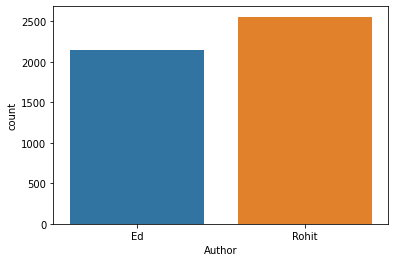

In [38]:
# Most Active Author in the chat
author_value_counts= df['Author'].value_counts() #--- Number of messages per author
sns.countplot(x="Author", data=df)

Hence Rohit sent more messages per hour than Ed.

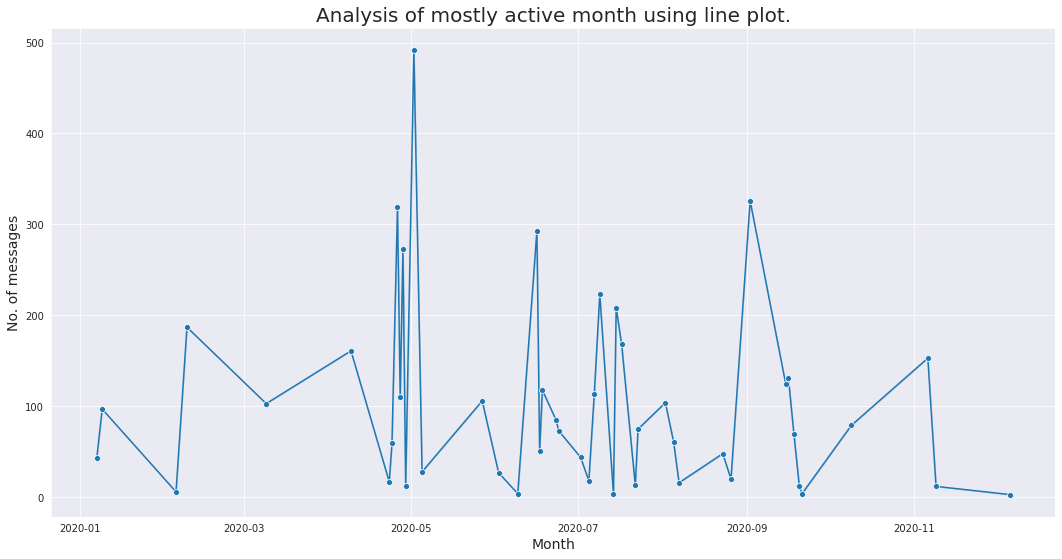

In [39]:
z = df['Date'].value_counts() 
z1 = z.to_dict() 
df['Msg_count_monthly'] = df['Date'].map(z1)
plt.figure(figsize=(18,9))
sns.set_style("darkgrid")
sns.lineplot(data=df,x='Date',y='Msg_count_monthly',markers=True,marker='o')
plt.xlabel('Month',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of mostly active month using line plot.',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()

Hence most active month in this Whatsapp chat is May 2020.

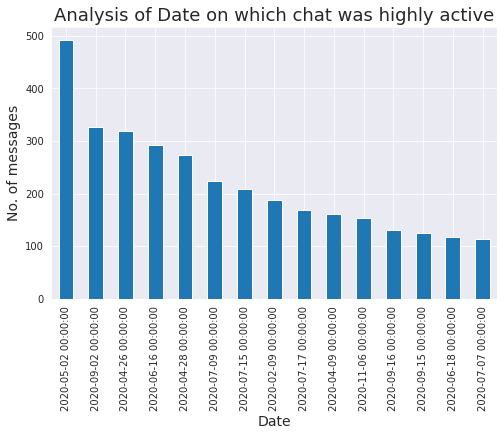

In [40]:
# Date on which the chat highly active.
plt.figure(figsize=(8,5))
df['Date_High']= df['Date'].value_counts().head(15).plot.bar()
plt.xlabel('Date',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of Date on which chat was highly active',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()


Therefore, the chat was more active on 02/05/2020 and least active on 07/07/2020.

In [41]:
lst = []
for i in df['Time']:
  out_time = datetime.strftime(datetime.strptime(i,"%I:%M %p"),"%H:%M")
  lst.append(out_time)
df['24H_Time'] = lst
df['Hours'] = df['24H_Time'].apply(lambda x : x.split(':')[0])

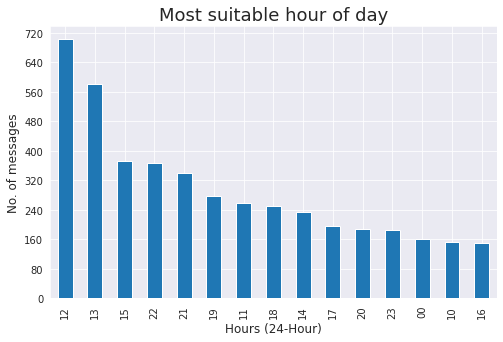

In [42]:
# Most suitable hour of day, whenever there will more chances of getting responce from group members.
plt.figure(figsize=(8,5))
std_time = df['Hours'].value_counts().head(15)
s_T = std_time.plot.bar()
s_T.yaxis.set_major_locator(MaxNLocator(integer=True))  # Converting y axis data to integer
plt.xlabel('Hours (24-Hour)',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Most suitable hour of day',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

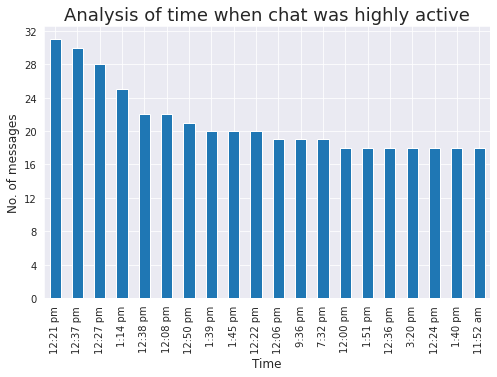

In [43]:
# Time whenever the chat is highly active
plt.figure(figsize=(8,5))
t = df['Time'].value_counts().head(20)
tx = t.plot.bar()
tx.yaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Analysis of time when chat was highly active',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

Therefore, the chat is highly active at 12.21pm and gradually decreases as time increases.